In [3]:
import sys
copypath = ['../models', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib/python27.zip', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib/python2.7', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib/python2.7/plat-linux2', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib/python2.7/lib-tk', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib/python2.7/lib-old', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib/python2.7/lib-dynload', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib/python2.7/site-packages', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg']
for p in reversed(copypath):
    sys.path.insert(0, p)
import setGPU

setGPU: Setting GPU to: 0


In [4]:
%matplotlib inline

In [5]:
import h5py
import glob
import numpy as np

In [19]:
# need afs password to read from eos
#import os
#import getpass
#os.system("echo %s| kinit" %getpass.getpass())

In [7]:
# open the  datasets
fileIn = h5py.File("../DATA/ttbar_lepFilter_13TeV_JetImage.h5")
truth = fileIn.get("jetMomenta")
raw = fileIn.get("rawJetMomenta")
features = fileIn.get("jetImages")

# Prepare train and test samples



In [8]:
# we only care about the jet pT being > 100 GeV
truth = truth[:,0]
truth = truth > 100.

In [9]:
from sklearn.preprocessing import MinMaxScaler
# normalize raw inputs and outputs between 0 and 1
scaler = MinMaxScaler()
print(scaler.fit(raw))
maxVal = scaler.data_max_
minVal = scaler.data_min_
raw = (raw-minVal)/(maxVal-minVal)
#truth = (truth-minVal)/(maxVal-minVal)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [10]:
iSplit = int(0.7*len(truth))
x_image_train = features[:iSplit, :, :, :]
x_image_test = features[iSplit:, :, :, :]
x_raw_train = raw[:iSplit, :]
x_raw_test = raw[iSplit:, :]
y_train = truth[:iSplit]
y_test = truth[iSplit:]

In [11]:
x_image_test = np.reshape(x_image_test, (x_image_test.shape[0], x_image_test.shape[1],
                                         x_image_test.shape[2], x_image_test.shape[3], 1))
x_image_train = np.reshape(x_image_train, (x_image_train.shape[0], x_image_train.shape[1],
                                           x_image_train.shape[2], x_image_train.shape[3], 1))

In [12]:
print(x_raw_test.shape, x_raw_train.shape)

((207916, 4), (485136, 4))


# build the model

In [14]:
# keras imports
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, Conv3D, Dropout, Flatten, Concatenate, Reshape, BatchNormalization
from keras.layers import MaxPooling2D, MaxPooling3D
from keras.utils import plot_model
from keras import regularizers
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau#, TerminateOnNaN

In [15]:
batch_size = 128
img_rows, img_cols = 20, 20
nImages = 2

In [16]:
image_shape = (img_rows, img_cols, nImages, 1)
####
# this is the raw pT
InputRaw = Input(shape=(4,))
x2 = BatchNormalization()(InputRaw)
# this is the input image
inputImage = Input(shape=(image_shape))
x = BatchNormalization()(inputImage)
x = Conv3D(5, kernel_size=(3, 3, 2), data_format="channels_last", strides=(1, 1, 1), activation='relu', input_shape=image_shape)(x)
x = Dropout(0.25)(x)
#x = MaxPooling3D(pool_size=(2, 2, 1))(x)
# from 3D to 2D
print(x.shape)
x = Reshape((18, 18, 5), input_shape=(18, 18, 1, 5))(x)
x = Conv2D(1, kernel_size=(3, 3), activation='relu', input_shape=image_shape)(x)
x = Dropout(0.25)(x)
#x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
dense = Concatenate(axis=1)([x, x2])
dense = Dense(10, activation='relu')(dense)
dense = Dropout(0.25)(dense)
output = Dense(1, activation='sigmoid')(dense)
####
model = Model(input=(InputRaw,inputImage), output=output)

(?, 18, 18, 1, 5)


/home/ec2-user/miniconda2/envs/keras-training/lib/python2.7/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=(<tf.Tenso...)`
  '` call to the Keras 2 API: ' + signature)


In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()
# plot graph
# plot_model(model)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 20, 20, 2, 1)  0                                            
____________________________________________________________________________________________________
batch_normalization_2 (BatchNorm (None, 20, 20, 2, 1)  4                                            
____________________________________________________________________________________________________
conv3d_1 (Conv3D)                (None, 18, 18, 1, 5)  95                                           
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 18, 18, 1, 5)  0                                            
___________________________________________________________________________________________

In [18]:
# train 
history = model.fit([x_raw_train, x_image_train], y_train, epochs=150, batch_size=batch_size, verbose = 2,
                validation_data=([x_raw_test, x_image_test], y_test),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
                ])
                #TerminateOnNaN()])

Train on 485136 samples, validate on 207916 samples
Epoch 1/150
44s - loss: 0.2024 - val_loss: 0.1496
Epoch 2/150
42s - loss: 0.1661 - val_loss: 0.1450
Epoch 3/150
42s - loss: 0.1623 - val_loss: 0.1429
Epoch 4/150
42s - loss: 0.1606 - val_loss: 0.1397
Epoch 5/150
42s - loss: 0.1608 - val_loss: 0.1461
Epoch 6/150
42s - loss: 0.1593 - val_loss: 0.1383
Epoch 7/150
43s - loss: 0.1588 - val_loss: 0.1394
Epoch 8/150
44s - loss: 0.1585 - val_loss: 0.1380
Epoch 9/150
42s - loss: 0.1586 - val_loss: 0.1388
Epoch 10/150
42s - loss: 0.1581 - val_loss: 0.1375
Epoch 11/150
42s - loss: 0.1582 - val_loss: 0.1393
Epoch 12/150
42s - loss: 0.1578 - val_loss: 0.1376
Epoch 13/150
42s - loss: 0.1577 - val_loss: 0.1369
Epoch 14/150
42s - loss: 0.1574 - val_loss: 0.1377
Epoch 15/150
42s - loss: 0.1574 - val_loss: 0.1392
Epoch 16/150

Epoch 00015: reducing learning rate to 0.00010000000475.
42s - loss: 0.1572 - val_loss: 0.1388
Epoch 17/150
42s - loss: 0.1561 - val_loss: 0.1364
Epoch 18/150
42s - loss: 0.1549 

# Loss at early stop:
- Adam with mse: 
- Adam with logcosh: 
- Adadelta with mse: 
- Adadelta with logcosh: 

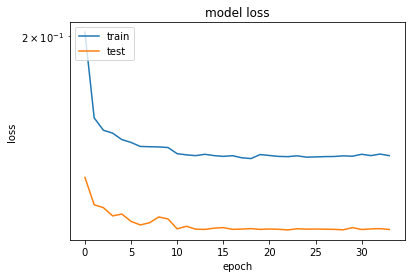

In [25]:
import matplotlib.pyplot as plt
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#

In [65]:
#put pT back in its range
pTraw = minVal[0] + x_raw_test[:,0]*(maxVal[0]-minVal[0])
pTreco = minVal[0] + np.reshape(y_test, (y_test.shape[0],))*(maxVal[0]-minVal[0])

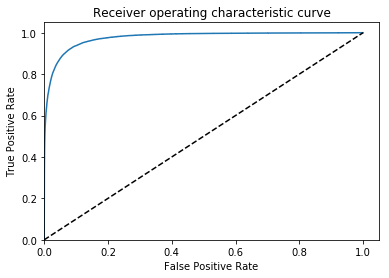

AUC: 0.975855

Accuracy score: 0.945646
Precision score: 0.919538
RAW True Positive Rate = 0.945169
RAW False Positive Rate = 0.859572


In [66]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
# build ROC curve
y_score = model.predict([x_raw_test, x_image_test])
# 
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='CNN ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.show()
print('AUC: %f\n' %(roc_auc))
myscore = y_score.reshape(y_score.shape[0],).round()
print('Accuracy score: %f' % accuracy_score(y_test, myscore))
print('Precision score: %f' % precision_score(y_test, myscore, average='macro'))
y_scoreRAW = pTraw>100.
rawTP = np.sum((y_scoreRAW == True) * (y_test == True))/np.sum(y_test)
rawFP = np.sum((y_scoreRAW == True) * (y_test == False))/np.sum(y_test)
print("RAW True Positive Rate = %f" %rawTP)
print("RAW False Positive Rate = %f" %rawFP)

In [67]:
eff = 0.95
goodTPR = tpr[tpr>eff][0]
goodFPR = fpr[tpr>eff][0]
goorThreshold = thresholds[tpr>eff][0]
print(goodTPR, goodFPR, goorThreshold)

0.950018186227 0.118725846653 0.102633


In [68]:
print((y_score>goorThreshold).shape)
keepEvt = y_score>goorThreshold
keepEvt = np.reshape(keepEvt, (keepEvt.shape[0],))
print(keepEvt.shape)

(207916, 1)
(207916,)


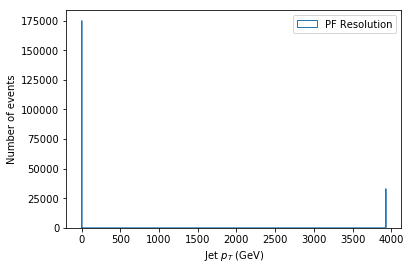

In [69]:
# now build ingredients to the turn-on curves TO BE DONE
#plt.xlim(15., 100.)
#plt.ylim(0., 1.)
countsDEN, binsDEN, barsDEN = plt.hist(pTreco, bins = 1000, histtype = 'step')
#countsNUM, binsNUM, barsNUM = plt.hist(pTreco[keepEvt], bins = 1000, histtype = 'step')
#countsNUMRAW, binsNUMRAW, barsNUMRAW = plt.hist(pTreco[pTraw>40.], bins = 1000, histtype = 'step')
plt.ylabel('Number of events')
plt.xlabel('Jet $p_T$ (GeV)')
plt.legend(['PF Resolution','CNN Resolution','RAW Resolution'], loc='upper right')
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


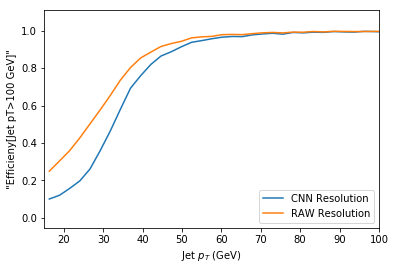

In [365]:
# build efficiencies 
eff_CNN = np.nan_to_num(countsNUM/countsDEN)
#err_CNN = np.nan_to_num(np.sqrt(eff_CNN*(1.-eff_CNN)/countsDEN))
#
eff_RAW = np.nan_to_num(countsNUMRAW/countsDEN)
#err_RAW = np.nan_to_num(np.sqrt(eff_RAW*(1.-eff_RAW)/countsDEN))
#
plt.xlim(15., 100.)
plt.plot(bins, eff_CNN)
plt.plot(bins, eff_RAW)
#
plt.ylabel('"Efficieny[Jet pT>100 GeV]"')
plt.xlabel('Jet $p_T$ (GeV)')
plt.legend(['CNN Resolution','RAW Resolution'], loc='lower right')
plt.show()